# **Fake News Detection**

## Table of contents
* [Imports](#imports)
* [Data analysis](#data-analysis)
    * [WELFake](#2.1)
    * [Fake_news_net](#2.2)
    * [Fake True](#2.3)
* [Data preprocessing](#3)
    * [WELFake](#3.1)
        * [Bag of words](#3.1.1)
        * [Word 2 vec](#3.1.2)
        * [Split data](#3.1.3)
    * [Fake_news_net](#3.2)
        * [Bag of words](#3.2.1)
        * [Word 2 vec](#3.2.2)
        * [Split data](#3.2.3)
    * [Fake True](#3.3)
        * [Bag of words](#3.3.1)
        * [Word 2 vec](#3.3.2)
        * [Split data](#3.3.3)
* [Models](#4)
    * [WELFake](#4.1)
        * [Bag of words](#4.1.1)
        * [Word 2 vec](#4.1.2)
    * [Fake_news_net](#4.2)
        * [Bag of words](#4.2.1)
        * [Word 2 vec](#4.2.2)
    * [Fake True](#4.3)
        * [Bag of words](#4.3.1)
        * [Word 2 vec](#4.3.2)
* [Hyparameters tunning](#5)
    * [WELFake](#5.1)
        * [Bag of words](#5.1.1)
        * [Word 2 vec](#5.1.2)
    * [Fake_news_net](#5.2)
        * [Bag of words](#5.2.1)
        * [Word 2 vec](#5.2.2)
    * [Fake True](#5.3)
        * [Bag of words](#5.3.1)
        * [Word 2 vec](#5.3.2)
* [Cross-validation](#6)
    * [WELFake](#6.1)
        * [Bag of words](#6.1.1)
        * [Word 2 vec](#6.1.2)
    * [Fake_news_net](#6.2)
        * [Bag of words](#6.2.1)
        * [Word 2 vec](#6.2.2)
    * [Fake True](#6.3)
        * [Bag of words](#6.3.1)
        * [Word 2 vec](#6.3.2)

# **1. Imports** <a name="imports"></a>

In [1]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import nltk
import optuna

import torch
import torch.nn as nn
import torch.optim as optim

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

from ydata_profiling import ProfileReport
from wordcloud import WordCloud
from gensim.models import Word2Vec
from tqdm import tqdm


nltk.download('stopwords')
nltk.download('wordnet')

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/przemek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/przemek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
wel_fake = pd.read_csv('data/WELFake_Dataset.csv', index_col = 0)
fake_news_net = pd.read_csv('data/FakeNewsNet.csv', index_col=False)
true = pd.read_csv('data/true.csv', index_col=False)
fake = pd.read_csv('data/fake.csv', index_col=False)

# **2. Data analysis** <a name="data-analysis"></a>

In [3]:
def balance_plot(df, label, plot_name):
    df.groupby(label)[label].count().plot(kind='pie', autopct='%1.1f%%', title=plot_name)

In [4]:
stopwords = set(stopwords.words('english'))
def word_cloud_plot(df, groupby, agg_column):
    wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df.groupby(groupby)[agg_column].sum()[0])
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## **2.1 WEL Fake dataset** <a name="2.1"></a>

In [5]:
wel_fake

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [6]:
#ProfileReport(wel_fake, title='WELFake').to_file('WELFake.html')

In [7]:
missing_values = wel_fake.isnull().sum()
missing_values

title    558
text      39
label      0
dtype: int64

In [8]:
wel_fake.fillna(" ", inplace=True)
wel_fake.dropna(inplace=True)
wel_fake = wel_fake.reset_index(drop=True)

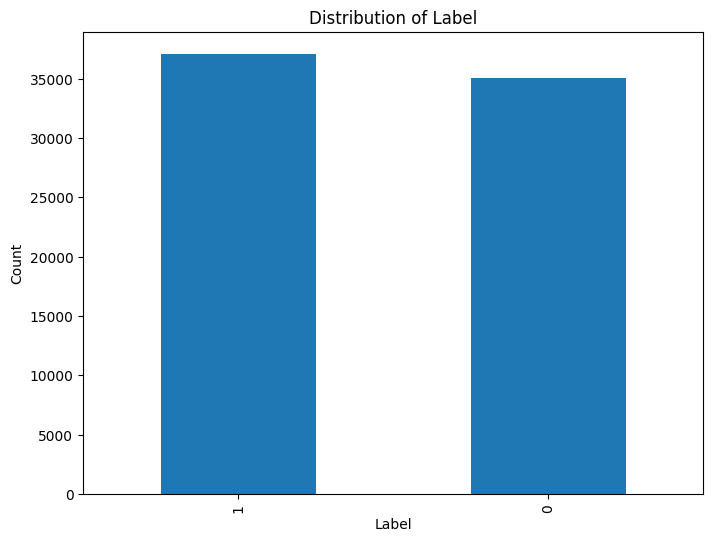

In [9]:
plt.figure(figsize=(8, 6))
wel_fake['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Label')
plt.show()

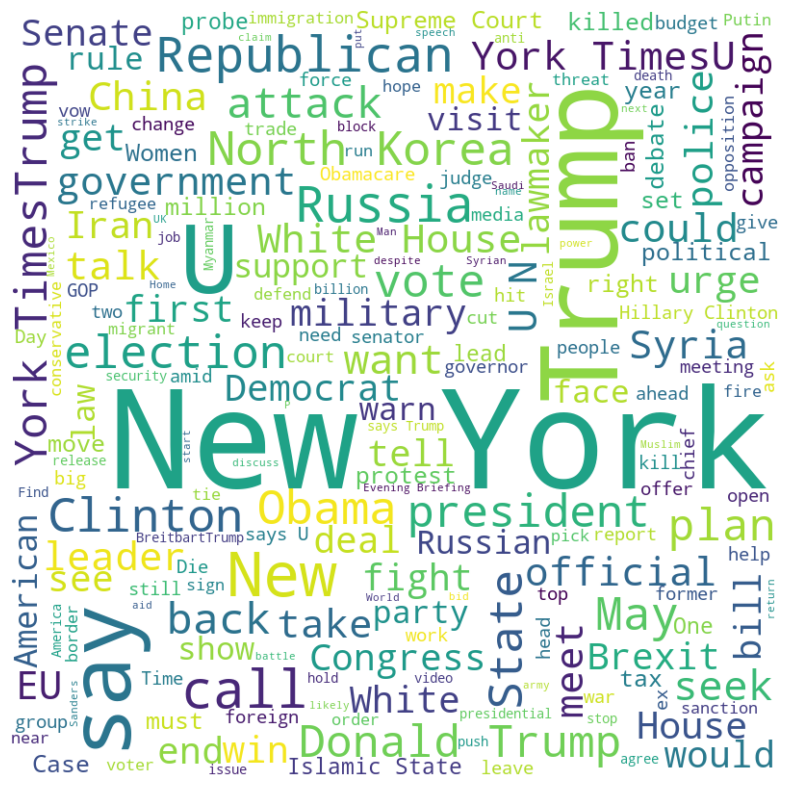

In [10]:
word_cloud_plot(wel_fake,'label', 'title')

## **2.2 Fake news net dataset** <a name="2.2"></a>

In [11]:
fake_news_net

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


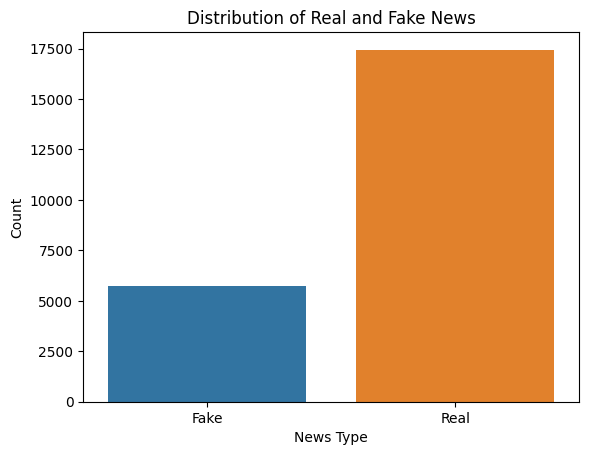

In [12]:
sns.countplot(x='real', data=fake_news_net)
plt.title('Distribution of Real and Fake News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

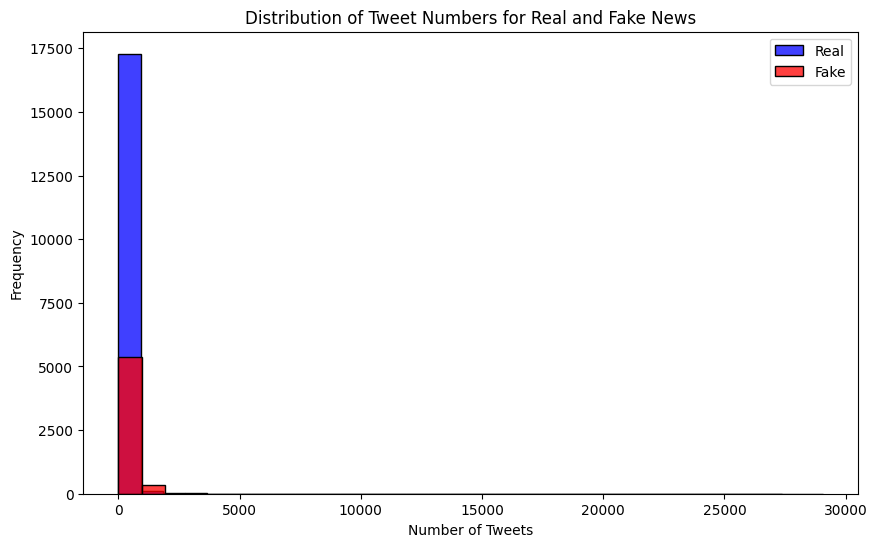

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(fake_news_net[fake_news_net['real'] == 1]['tweet_num'], bins=30, color='blue', label='Real')
sns.histplot(fake_news_net[fake_news_net['real'] == 0]['tweet_num'], bins=30, color='red', label='Fake')
plt.title('Distribution of Tweet Numbers for Real and Fake News')
plt.xlabel('Number of Tweets')
plt.ylabel('Frequency')
plt.legend()
plt.show()

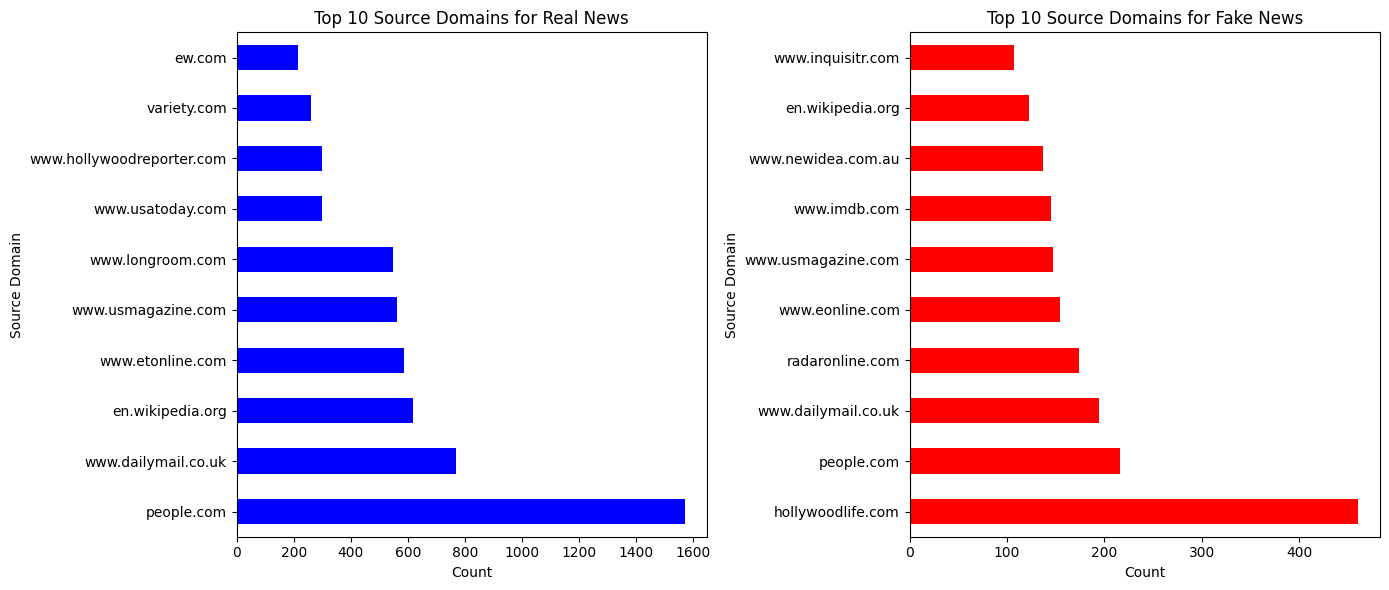

In [14]:
# Top 10 source domains for real and fake news
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
fake_news_net[fake_news_net['real'] == 1]['source_domain'].value_counts().head(10).plot(kind='barh', color='blue')
plt.title('Top 10 Source Domains for Real News')
plt.xlabel('Count')
plt.ylabel('Source Domain')

plt.subplot(1, 2, 2)
fake_news_net[fake_news_net['real'] == 0]['source_domain'].value_counts().head(10).plot(kind='barh', color='red')
plt.title('Top 10 Source Domains for Fake News')
plt.xlabel('Count')
plt.ylabel('Source Domain')

plt.tight_layout()
plt.show()

In [15]:
fake_news_net.isnull().sum()

title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64

In [16]:
#ProfileReport(fake_news_net, title='FakeNewsNet').to_file('FakeNewsNet.html')

Shape after removing missing values: (22866, 5)
Shape of balanced dataset: (10990, 5)


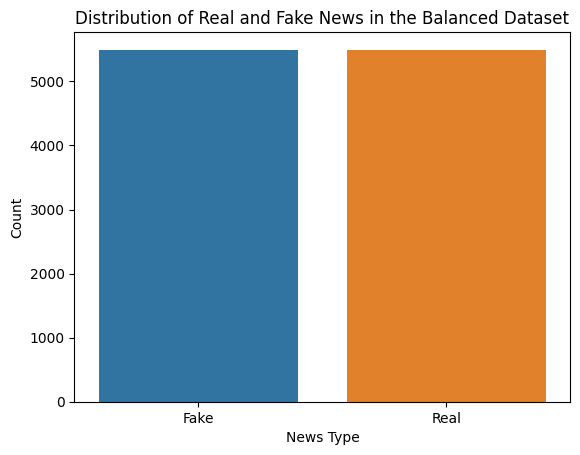

In [17]:
fake_news_net = fake_news_net.dropna()

print('Shape after removing missing values:', fake_news_net.shape)

real_news = fake_news_net[fake_news_net['real'] == 1]
fake_news = fake_news_net[fake_news_net['real'] == 0]

real_news_downsampled = real_news.sample(len(fake_news), random_state=1)

fake_news_net_balanced = pd.concat([real_news_downsampled, fake_news])

print('Shape of balanced dataset:', fake_news_net_balanced.shape)

sns.countplot(x='real', data=fake_news_net_balanced)
plt.title('Distribution of Real and Fake News in the Balanced Dataset')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

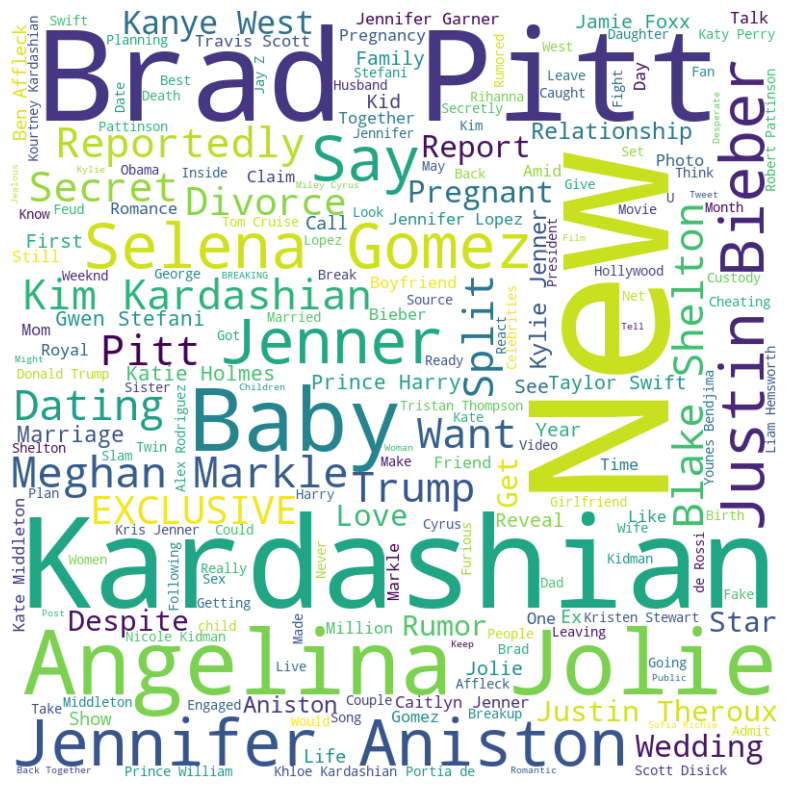

In [18]:
word_cloud_plot(fake_news_net,'real', 'title')

In [19]:
fake_news_net = fake_news_net_balanced

## **2.3 Fake and True dataset** <a name="2.3"></a>

In [20]:
fake['label'] = 0

true['label'] = 1

In [21]:
fake_true = pd.concat([fake, true]).reset_index(drop=True)

In [22]:
#ProfileReport(fake_true, title='FakeTrue').to_file('FakeTrue.html')

In [23]:
fake_true

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


In [24]:
fake_true.groupby(['subject', 'label']).count()

,,title,text,date
subject,label,,,
Government News,0,1570,1570,1570
Middle-east,0,778,778,778
News,0,9050,9050,9050
US_News,0,783,783,783
left-news,0,4459,4459,4459
politics,0,6841,6841,6841
politicsNews,1,11272,11272,11272
worldnews,1,10145,10145,10145


In [25]:
fake_true.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

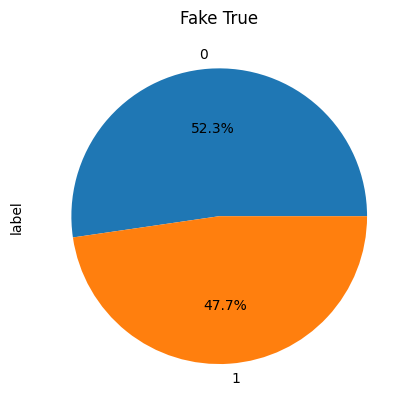

In [26]:
balance_plot(fake_true,'label', 'Fake True')

<AxesSubplot: >

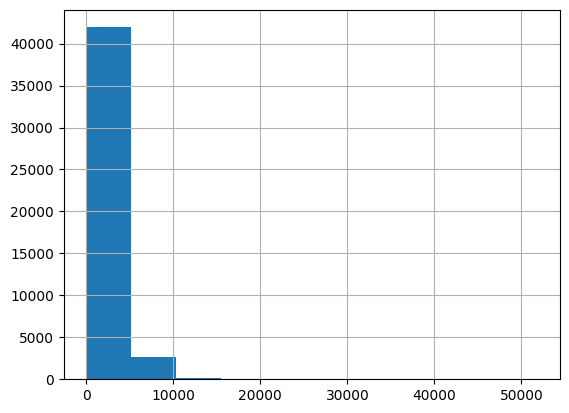

In [27]:
fake_true['text'].str.len().hist()

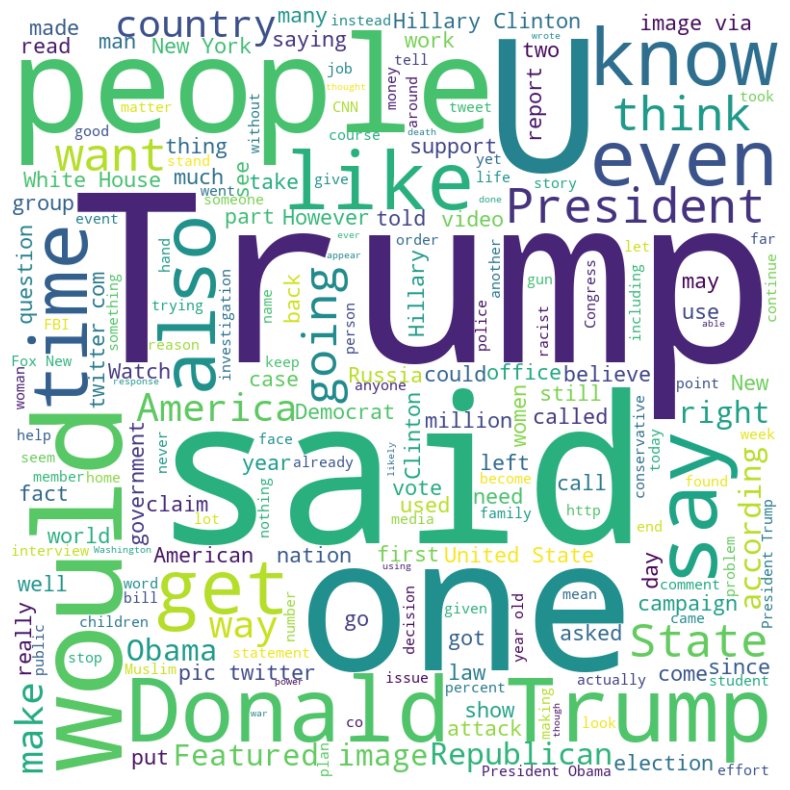

In [28]:
word_cloud_plot(fake_true,'label', 'text')

# **3. Data preprocessing** <a name="3"></a>

In [29]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]

    preprocessed_text = ' '.join(words)
    
    if preprocessed_text == "":
        preprocessed_text = "placeholder"

    return preprocessed_text

## **3.1 WEL Fake preprocessing** <a name="3.1"></a>

In [ ]:
wel_fake['text'] = wel_fake['text'].apply(preprocess_text)
wel_fake.head()

### **3.1.1 Bag of Words** <a name="3.1.1"></a>

In [ ]:
vectorizer = CountVectorizer(min_df=2, max_features=1000)

bow = vectorizer.fit_transform(wel_fake['text'])
feature_names = vectorizer.get_feature_names_out()
X_bow_wel = bow.toarray()

X_bow_wel.shape

### **Split Data**

In [ ]:
y_wel = wel_fake['label']
X_train_bow_wel, X_test_bow_wel, y_train_bow_wel, y_test_bow_wel = train_test_split(X_bow_wel, y_wel, test_size=0.2, random_state=42)
X_train_bow_wel, X_val_bow_wel, y_train_bow_wel, y_val_bow_wel = train_test_split(X_train_bow_wel, y_train_bow_wel, test_size=0.2, random_state=42)

In [ ]:
y_train_bow_wel.value_counts(normalize=True) #imbalance check

### **3.1.2 Word 2 Vec** <a name="3.1.2"></a>

In [ ]:
sentences = wel_fake['text'].apply(lambda x: x.split())
model = Word2Vec(sentences, min_count=1)

print(model)

In [ ]:
def w2v_train_test_prepatarion(data):
    X_train_vec = [] 
    for sentence in data:
        sentence_vec = []
        for word in sentence.split():
            if word in model.wv.key_to_index:
                sentence_vec.append(model.wv[word])
            else:
                sentence_vec.append(np.zeros(100)) #100 equal to vector_size in w2v_model
        X_train_vec.append(np.mean(sentence_vec, axis=0))
    return X_train_vec

In [ ]:
X_w2v_wel = w2v_train_test_prepatarion(wel_fake['text'])

In [ ]:
X_w2v_wel = pd.DataFrame(X_w2v_wel)

### **3.1.3 Split Data** <a name="3.1.3"></a>

In [ ]:
X_train_w2v_wel, X_test_w2v_wel, y_train_w2v_wel, y_test_w2v_wel = train_test_split(X_w2v_wel, y_wel, test_size=0.2, random_state=42)
X_train_w2v_wel, X_val_w2v_wel, y_train_w2v_wel, y_val_w2v_wel = train_test_split(X_train_w2v_wel, y_train_w2v_wel, test_size=0.2, random_state=42)

In [ ]:
y_train_w2v_wel.value_counts(normalize=True) #imbalance check

## **3.2 Fake News Net preprocessing** <a name="3.2"></a>

In [ ]:
fake_news_net['title'] = fake_news_net['title'].apply(preprocess_text)
fake_news_net.head()

### 3.2.1 Bag of Words <a name="3.2.1"></a>

In [ ]:
vectorizer = CountVectorizer(min_df=2, max_features=1000)

bow = vectorizer.fit_transform(fake_news_net['title'])
feature_names = vectorizer.get_feature_names_out()
X_bow_net = pd.DataFrame(bow.toarray(), columns=feature_names)

X_bow.shape

In [ ]:
y = fake_news_net['real']
X_train_bow_net, X_test_bow_net, y_train_bow_net, y_test_bow_net = train_test_split(X_bow_net, y, test_size=0.2, random_state=42)
X_train_bow_net, X_val_bow_net, y_train_bow_net, y_val_bow_net = train_test_split(X_train_bow_net, y_train_bow_net, test_size=0.2, random_state=42)

In [ ]:
y_train_bow_net.value_counts(normalize=True) #imbalance check

### **3.2.2 Bag of Word 2 Vec** <a name="3.2.2"></a>

In [ ]:
sentences = fake_news_net['title'].apply(lambda x: x.split())
model = Word2Vec(sentences, min_count=1)

print(model)

In [ ]:
X_w2v_net = w2v_train_test_prepatarion(fake_news_net['title'])

### 3.2.3 Split Data <a name="3.2.3"></a>

In [ ]:
y = fake_news_net['real']
X_train_w2v_net, X_test_w2v_net, y_train_w2v_net, y_test_w2v_net = train_test_split(X_w2v_net, y, test_size=0.2, random_state=42)
X_train_w2v_net, X_val_w2v_net, y_train_w2v_net, y_val_w2v_net = train_test_split(X_train_w2v_net, y_train_w2v_net, test_size=0.2, random_state=42)

In [ ]:
y_train_w2v_net.value_counts(normalize=True) #imbalance check

## **3.3 Fake and True preprocessing** <a name="3.3"></a>

In [ ]:
fake_true.duplicated().sum()

In [ ]:
fake_true.drop_duplicates(inplace=True)

In [ ]:
fake_true['text'] = fake_true['text'].apply(preprocess_text)
fake_true.head()

### **3.3.1 Bag of words** <a name="3.3.1"></a>

In [ ]:
vectorizer = CountVectorizer(min_df=2, max_features=1000)

bow = vectorizer.fit_transform(fake_true['text'])
feature_names = vectorizer.get_feature_names_out()
X_bow_ft = pd.DataFrame(bow.toarray(), columns=feature_names)

X_bow.shape

In [ ]:
y = fake_true['label']
X_train_bow_ft, X_test_bow_ft, y_train_bow_ft, y_test_bow_ft = train_test_split(X_bow_ft, y, test_size=0.2, random_state=42)
X_train_bow_ft, X_val_bow_ft, y_train_bow_ft, y_val_bow_ft = train_test_split(X_train_bow_ft, y_train_bow_ft, test_size=0.2, random_state=42)

In [ ]:
y_train_bow_ft.value_counts(normalize=True) #imbalance check

### **3.3.2 Word 2 Vec** <a name="3.3.2"></a>

In [ ]:
sentences = fake_true['text'].apply(lambda x: x.split())
model = Word2Vec(sentences, min_count=1)

print(model)

In [ ]:
X_w2v_ft = w2v_train_test_prepatarion(fake_true['text'])

### 3.3.3 Split Data <a name="3.3.3"></a>

In [ ]:
y = fake_true['label']
X_train_w2v_ft, X_test_w2v_ft,y_train_w2v_ft, y_test_w2v_ft = train_test_split(X_w2v_ft, y, test_size=0.2, random_state=42)
X_train_w2v_ft, X_val_w2v_ft,y_train_w2v_ft, y_val_w2v_ft = train_test_split(X_train_w2v_ft, y_train_w2v_ft, test_size=0.2, random_state=42)

In [ ]:
y_train_w2v_ft.value_counts(normalize=True) #imbalance check

## 4. Models <a name="4"></a>

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available() else "cpu" )
print(f"Using {device} device")

In [ ]:
torch.set_default_dtype(torch.float32)

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs =torch.sigmoid( self.linear(x))
        return outputs

In [ ]:
def train(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (inputs, target) in tqdm(enumerate(train_loader), desc="Epoch %s: " % (epoch+1), total=train_loader.__len__()):
            inputs = inputs.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), target)
            loss.backward()
            optimizer.step()
            
        model.eval()
        valid_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, target in valid_loader:
                inputs = inputs.to(device)
                target = target.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), target)
                valid_loss += loss.item() * inputs.size(0)
                pred = (outputs > 0.5).float() 
                correct += (pred.squeeze() == target).float().sum().item()
                
        valid_loss /= len(valid_loader.dataset)
        valid_acc = correct / len(valid_loader.dataset)
        print ('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item(), valid_loss, valid_acc))

In [ ]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, target in data_loader:
            inputs = inputs.to(device)
            target = target.to(device)
            outputs = model(inputs)
            pred = (outputs > 0.5).float() 
            predictions.append(pred.squeeze().cpu().numpy())
    predictions = np.concatenate(predictions)
    return predictions

In [ ]:
class LoadDataset(Dataset): #created due to lack of memory
    def __init__(self, X, y, use_toarray=False):
        self.X = X
        self.y = y
        self.use_toarray = use_toarray

    def __getitem__(self, index):
        X_dense = torch.tensor(self.X[index]).float()
        y_dense = torch.tensor(self.y[index]).float()
        return X_dense, y_dense

    def __len__(self):
        return len(self.y)

In [ ]:
lr=0.01
epochs_num=2
criterion = nn.BCELoss()

## 4.1 WELFake <a name="4.1"></a>

### 4.1.1 Bag of Words <a name="4.1.1"></a>

In [ ]:
y_train_bow_wel = y_train_bow_wel.reset_index(drop=True)
y_val_bow_wel = y_val_bow_wel.reset_index(drop=True)
y_test_bow_wel = y_test_bow_wel.reset_index(drop=True)

In [ ]:
valid_loader = LoadDataset(X_val_bow_wel, y_val_bow_wel)
val_loader_bow_wel= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_bow_wel, y_train_bow_wel)
train_loader_bow_wel= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [ ]:
model_bow_wel = LogisticRegression(input_dim=X_train_bow_wel.shape[1], output_dim=1)
model_bow_wel.to(device)
optimizer = torch.optim.Adam(model_bow_wel.parameters(), lr=lr)

In [ ]:
%%time
train(model_bow_wel, train_loader_bow_wel, val_loader_bow_wel, criterion, optimizer, device, epochs_num)

In [ ]:
test_loader = LoadDataset(X_test_bow_wel, y_test_bow_wel)
test_loader_wel= DataLoader(test_loader, batch_size=32)

In [ ]:
y_pred_wel = predict(model_bow_wel, test_loader_wel)

print(classification_report(y_test_bow_wel, y_pred_wel))

### 4.1.2 Word 2 vec <a name="4.1.2"></a>

In [ ]:
y_train_w2v_wel = y_train_w2v_wel.reset_index(drop=True)
y_val_w2v_wel = y_val_w2v_wel.reset_index(drop=True)
y_test_w2v_wel = y_test_w2v_wel.reset_index(drop=True)

In [ ]:
valid_loader = LoadDataset(X_val_w2v_wel, y_val_w2v_wel,use_toarray=True)
val_loader_w2v_wel= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_w2v_wel, y_train_w2v_wel, use_toarray=True)
train_loader_w2v_wel= DataLoader(train_loader, 
                                 batch_size=32, 
                                 shuffle=True)

In [ ]:
model_w2v_wel = LogisticRegression(input_dim=100, output_dim=1)
model_w2v_wel.to(device)
optimizer = torch.optim.Adam(model_w2v_wel.parameters(), lr=lr)

In [ ]:
train(model_w2v_wel, train_loader_w2v_wel, val_loader_w2v_wel,  criterion, optimizer, device, epochs_num)

In [ ]:
test_loader = LoadDataset(X_test_w2v_wel, y_test_w2v_wel, use_toarray=True)
test_loader_w2v= DataLoader(test_loader, batch_size=32)

In [ ]:
y_pred_w2v = predict(model_w2v_wel, test_loader_w2v)

print(classification_report(y_test_w2v_wel, y_pred_w2v))

## 4.2 Fake_news_net <a name="4.2"></a>

### 4.2.1 Bag of words <a name="4.2.1"></a>

In [ ]:
y_train_bow_net = y_train_bow_net.reset_index(drop=True)
y_val_bow_net = y_val_bow_net.reset_index(drop=True)
y_test_bow_net = y_test_bow_net.reset_index(drop = True)

In [ ]:
valid_loader = LoadDataset(X_val_bow_net, y_val_bow_net)
val_loader_bow_net= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_bow_net, y_train_bow_net)
train_loader_bow_net= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [ ]:
model_bow_net = LogisticRegression(input_dim=X_train_bow_net.shape[1], output_dim=1)
model_bow_net.to(device)
optimizer = torch.optim.Adam(model_bow_net.parameters(), lr=lr)

In [ ]:
%%time
train(model_bow_net, train_loader_bow_net, val_loader_bow_net, criterion, optimizer, device, epochs_num)

In [ ]:
test_loader = LoadDataset(X_test_bow_net, y_test_bow_net)
test_loader_net= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [ ]:
y_pred_net = predict(model_bow_net, test_loader_net)

print(classification_report(y_test_bow_net, y_pred_net))

### 4.2.2 Word 2 vec <a name="4.2.2"></a>

In [ ]:
y_train_w2v_net = y_train_w2v_net.reset_index(drop=True)
y_val_w2v_net = y_val_w2v_net.reset_index(drop=True)
y_test_w2v_net = y_test_w2v_net.reset_index(drop = True)

In [ ]:
valid_loader = LoadDataset(X_val_w2v_net, y_val_w2v_net,use_toarray=True)
val_loader_w2v_net= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_w2v_net, y_train_w2v_net,use_toarray=True)
train_loader_w2v_net= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [ ]:
model_w2v_net = LogisticRegression(input_dim=100, output_dim=1)
model_w2v_net.to(device)
optimizer = torch.optim.Adam(model_w2v_net.parameters(), lr=lr)

In [ ]:
%%time
train(model_w2v_net, train_loader_w2v_net, val_loader_w2v_net, criterion, optimizer, device, epochs_num)

In [ ]:
test_loader = LoadDataset(X_test_w2v_net, y_test_w2v_net, use_toarray=True)
test_loader_net= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [ ]:
y_pred_net = predict(model_w2v_net, test_loader_net)

print(classification_report(y_test_w2v_net, y_pred_net))

## 4.3 Fake True <a name="4.3"></a>

### 4.3.1 Bag of words <a name="4.3.1"></a>

In [ ]:
y_train_bow_ft = y_train_bow_ft.reset_index(drop=True)
y_val_bow_ft = y_val_bow_ft.reset_index(drop=True)
y_test_bow_ft = y_test_bow_ft.reset_index(drop=True)


In [ ]:
valid_loader = LoadDataset(X_val_bow_ft, y_val_bow_ft)
val_loader_bow_ft= DataLoader(valid_loader, 
                          batch_size=32, 
                          shuffle=True)

train_loader = LoadDataset(X_train_bow_ft, y_train_bow_ft)
train_loader_bow_ft= DataLoader(train_loader, 
                            batch_size=32, 
                            shuffle=True)

In [ ]:
model_bow_ft = LogisticRegression(input_dim=X_train_bow_ft.shape[1], output_dim=1)
model_bow_ft.to(device)
optimizer = torch.optim.Adam(model_bow_ft.parameters(), lr=lr)

In [ ]:
%%time
train(model_bow_ft, train_loader_bow_ft, val_loader_bow_ft, criterion, optimizer, device, epochs_num)

In [ ]:
test_loader = LoadDataset(X_test_bow_ft, y_test_bow_ft)
test_loader_ft= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [ ]:
y_pred_ft = predict(model_bow_ft, test_loader_ft)

print(classification_report(y_test_bow_ft, y_pred_ft))

### 4.3.2 Word 2 vec <a name="4.3.2"></a>

In [ ]:
y_train_w2v_ft = y_train_w2v_ft.reset_index(drop=True)
y_val_w2v_ft = y_val_w2v_ft.reset_index(drop=True)
y_test_w2v_ft = y_test_w2v_ft.reset_index(drop = True)

In [ ]:
valid_loader = LoadDataset(X_val_w2v_ft, y_val_w2v_ft,use_toarray=True)
val_loader_w2v_ft= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_w2v_ft, y_train_w2v_ft,use_toarray=True)
train_loader_w2v_ft= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [ ]:
model_w2v_ft = LogisticRegression(input_dim=100, output_dim=1)
model_w2v_ft.to(device)
optimizer = torch.optim.Adam(model_w2v_ft.parameters(), lr=lr)

In [ ]:
%%time
train(model_w2v_ft, train_loader_w2v_ft, val_loader_w2v_ft, criterion, optimizer, device, epochs_num)

In [ ]:
test_loader = LoadDataset(X_test_w2v_ft, y_test_w2v_ft, use_toarray=True)
test_loader_ft= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [ ]:
y_pred_ft = predict(model_w2v_ft, test_loader_ft)

print(classification_report(y_test_w2v_ft, y_pred_ft))

## **5. Hyperparameters tunning** <a name="5"></a>

In [ ]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-3, 1e-1)
    epochs = trial.suggest_int('epochs', 5, 50)


    model = LogisticRegression(input_dim=X, output_dim=1)
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            imputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).float().sum().item()

    return correct / total

In [ ]:
def callback(study, trial):
    print("Trial finished with value: ", trial.value)

### 5.1 WELFake <a name="5.1"></a>

### 5.1.1 Bag of Words <a name="5.1.1"></a>

In [ ]:
X = X_train_bow_wel.shape[1]
train_loader = train_loader_bow_wel
val_loader = val_loader_bow_wel

In [ ]:
%%time
study_bow_wel = optuna.create_study(direction='maximize')
study_bow_wel.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_bow_wel.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study_bow_wel)

### 5.1.2 Word 2 vec <a name="5.1.2"></a>

In [ ]:
X = 100
train_loader = train_loader_w2v_wel
val_loader = val_loader_w2v_wel

In [ ]:
%%time
study_w2v_wel = optuna.create_study(direction='maximize')
study_w2v_wel.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_w2v_wel.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study_w2v_wel)

### 5.2 Fake_new_net <a name="5.2"></a>

### 5.2.1 Bag of Words <a name="5.2.1"></a>

In [ ]:
X = X_train_bow_net.shape[1]
train_loader = train_loader_bow_net
val_loader = val_loader_bow_net

In [ ]:
%%time
study_bow_net = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_bow_net.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study)

### 5.2.2 Word 2 vec <a name="5.2.2"></a>

In [ ]:
X = 100
train_loader = train_loader_w2v_net
val_loader = val_loader_w2v_net

In [ ]:
%%time
study_w2v_net = optuna.create_study(direction='maximize')
study_w2v_net.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_w2v_net.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study_w2v_net)

### 5.3 Fake True <a name="5.3"></a>

### 5.3.1 Bag of Words <a name="5.3.1"></a>

In [ ]:
X = X_train_bow_ft.shape[1]
train_loader = train_loader_bow_ft
val_loader = val_loader_bow_ft

In [ ]:
%%time
study_bow_ft = optuna.create_study(direction='maximize')
study_bow_ft.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_bow_ft.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study_bow_ft)

### 5.3.2 Word 2 vec <a name="5.3.2"></a>

In [ ]:
X = 100
train_loader = train_loader_w2v_ft
val_loader = val_loader_w2v_ft

In [ ]:
%%time
study_w2v_ft = optuna.create_study(direction='maximize')
study_w2v_ft.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_w2v_ft.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study_w2v_ft)

## 6. Cross-validation <a name="6"></a>

In [ ]:
from sklearn.model_selection import StratifiedKFold

def train_one_fold(model, train_loader, criterion, optimizer, device):
    model.train()
    for batch_idx, (inputs, target) in tqdm(enumerate(train_loader), desc="Training: ", total=train_loader.__len__()):
        inputs = inputs.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()

def validate_one_fold(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, target in valid_loader:
            inputs = inputs.to(device)
            target = target.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), target)
            valid_loss += loss.item() * inputs.size(0)
            pred = (outputs > 0.5).float() 
            correct += (pred.squeeze() == target).float().sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_acc = correct / len(valid_loader.dataset)
    print ('Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(valid_loss, valid_acc))
    return valid_acc

def stratified_cross_validation(X, y,criterion, device, num_epochs):
    skf = StratifiedKFold(n_splits=5)
    acc_per_fold = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print(f"Training fold {fold+1}")
        
        X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]
        
        model = LogisticRegression(input_dim=X_train_fold.shape[1], output_dim=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        train_dataset = LoadDataset(X_train_fold, y_train_fold)
        valid_dataset = LoadDataset(X_valid_fold, y_valid_fold)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
        
        model.to(device)
        
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}")
            train_one_fold(model, train_loader, criterion, optimizer, device)
            acc_per_fold.append(validate_one_fold(model, valid_loader, criterion, device))
    avg_acc = sum(acc_per_fold) / len(acc_per_fold)
    print('Average accuracy:', avg_acc)

### 6.1 WELFake <a name="6.1"></a> 

### 6.1.1 Bag of words <a name="6.1.1"></a>

In [ ]:
lr = study_bow_wel.best_params['lr']
epochs_num = study_bow_wel.best_params['epochs']

In [ ]:
stratified_cross_validation(X_bow_wel, y_wel, criterion, device, epochs_num)

### 6.1.2 Word 2 vec <a name="6.1.2"></a>

In [ ]:
lr = study_w2v_wel.best_params['lr']
epochs_num = study_w2v_wel.best_params['epochs']

In [ ]:
X_w2v_wel = pd.DataFrame(X_w2v_wel)

In [ ]:
stratified_cross_validation(X_w2v_wel.values, y_wel, criterion, device, epochs_num)

In [ ]:
print(np.array(X_w2v_wel).shape[0])

In [ ]:
print(y.shape[0])

### 6.2 Fake_news_net <a name="6.1"></a>

### 6.2.1 Bag of words <a name="6.2.1"></a>

### 6.2.2 Word 2 vec <a name="6.2.2"></a>